# load, modify xml file, development

In [1]:
import xml.etree.ElementTree as ET
import os

In [2]:
os.getenv("HOME")

'/Users/aponte'

In [12]:

def update_config(file_in, file_out=None, overwrite=False, **params):
    """ Modify an Ichthyop xml input file
    
    Parameters
    ----------
    file_in: str
        Input file
    file_out: str, optional
        Output file
    overwrite: boolean, optional
    **kwargs:
        parameters to be modified, e.g.
        initial_time="year 2011 month 01 day 01 at 01:00"
        
    """

    if file_out is None:
        file_out = file_in.replace(".xml", "_new.xml")
    
    tree = ET.parse(file_in)
    root = tree.getroot()
    
    modified = {k: False for k in params}

    for p in root.iter("parameter"):
        #print(p)
        #print(dir(p))
        #print(p.items())
        for k in p.iter("key"):
            #if k.text=="initial_time":
            if k.text in params:
                #print(k)
                #print(k.text)
                v = p.find("value")
                #print(v)
                #print(v.text)
                #v.text = "some new date"
                v.text = str(params[k.text])
                modified[k.text] = True

    assert all([b for k, b in modified.items()]), "One or several parameters were not modified"
                
    if overwrite or not os.path.isfile(file_out):
        tree.write(file_out)
        print("File {} has been generated".format(file_out))
    else:
        print("Nothing done")
    

cfg = dict(initial_time="year 2011 month 01 day 01 at 01:00",
           transport_duration="0010 day(s) 00 hour(s) 00 minute(s)",
           number_particles=500,
           lon_stain=-0.4,
           lat_stain=49.5,
           depth_stain=-0.0,
           radius_stain=100,
           thickness_stain=1.0,
          )
    

#update_config("taos_mars3d.xml", initial_time="year 2011 month 01 day 01 at 01:00")
update_config("taos_mars3d.xml", overwrite=True, **cfg)



File taos_mars3d_new.xml has been generated


---

List of relevant parameters:

- initial_time="year 2011 month 01 day 01 at 01:00"
- Transport duration="0010 day(s) 00 hour(s) 00 minute(s)"
- number_particles=50
- lon_stain=-0.4
- lat_stain=49.5
- depth_stain=-0.0
- radius_stain=100 [meters]
- thickness_stain=1.0 [meters]
- 

---

## launch runs

In [1]:
import taos.drifters as dr

In [2]:

cfg = dict(initial_time="year 2011 month 01 day 01 at 01:00",
           transport_duration="001 day(s) 00 hour(s) 00 minute(s)",
           number_particles=500,
          )

work_dir = "/home/datawork-lops-osi/aponte/taos/ichthy"

dr.ichthy("test", workdir=work_dir, **cfg)

Run will be stored in /home/datawork-lops-osi/aponte/taos/ichthy/test
File cfg.xml has been generated
7941314.datarmor0


---

## test sensitivity to number of input netcdf files

In [1]:
import taos.drifters as dr

work_dir = "/home/datawork-lops-osi/aponte/taos/ichthy"
work_dir = "/Users/aponte/tmp/ichty"
cfg = dict(initial_time="year 2011 month 01 day 01 at 01:00",
           transport_duration="001 day(s) 00 hour(s) 00 minute(s)",
           number_particles=500,
          )

In [2]:
# base_nc_path = "/home/datawork-lops-osi/aponte/taos/ichthy/MARC_F1-MARS3D-SEINE/"
dr.ichthy("test_many_input_files", workdir=work_dir, launch=False, **cfg)

Run will be stored in /Users/aponte/tmp/ichty/test_many_input_files
File cfg.xml has been generated


In [2]:
# base_nc_path = "/home/datawork-lops-osi/aponte/taos/ichthy/MARC_F1-MARS3D-SEINE-TMP/"
dr.ichthy("test_few_input_files", workdir=work_dir, **cfg)

Run will be stored in /home/datawork-lops-osi/aponte/taos/ichthy/test_few_input_files
File cfg.xml has been generated
7947244.datarmor0


---

## investigate diving issue

In [10]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import taos.mars as ms
import taos.drifters as dr

work_dir = "/home/datawork-lops-osi/aponte/taos/ichthy"

In [3]:
cfg = dict(initial_time="year 2012 month 01 day 01 at 01:00",
           transport_duration="010 day(s) 00 hour(s) 00 minute(s)",
           number_particles=500,
           lon_stain=-0.25,
           lat_stain=49.4,
           depth_stain=-0.0,
           radius_stain=1000,
           thickness_stain=1.0,
          )

In [4]:
cfg["age_max"] = 1.
dr.ichthy("test1", workdir=work_dir, **cfg)

cfg["age_max"] = 10.
dr.ichthy("test10", workdir=work_dir, **cfg)


Run will be stored in /home/datawork-lops-osi/aponte/taos/ichthy/test1
File cfg.xml has been generated
7940993.datarmor0
Run will be stored in /home/datawork-lops-osi/aponte/taos/ichthy/test10
File cfg.xml has been generated
7940994.datarmor0


In [4]:
def load_run(age_max):
    run = "test{}".format(age_max)
    run_dir = os.path.join(work_dir, run)
    dsr = dr.load_run_simple(run_dir)
    dsr = dr.normalize_time(dsr)
    return dsr

D = {a: load_run(a) for a in [1, 10]}

In [6]:
D[1]

<xarray.Dataset>
Dimensions:      (time: 241, drifter: 500, edge: 1188, latlon: 2)
Coordinates:
  * time         (time) float64 0.0 0.04167 0.08333 0.125 ... 9.917 9.958 10.0
Dimensions without coordinates: drifter, edge, latlon
Data variables:
    lon          (time, drifter) float32 ...
    lat          (time, drifter) float32 ...
    mortality    (time, drifter) int32 ...
    depth        (time, drifter) float32 ...
    region_edge  (edge, latlon) float32 ...
    date         (time) datetime64[ns] 2012-01-01T01:00:00 ... 2012-01-11T01:...
Attributes: (12/67)
    transport_dimension:                      3d
    release.schedule.is_enabled:              false
    release.schedule.events:                  "year 2010 month 05 day 13 at 1...
    app.time.initial_time:                    year 2012 month 01 day 01 at 01:00
    app.time.transport_duration:              010 day(s) 00 hour(s) 00 minute(s)
    app.time.time_step:                       300
    ...                                       ...
    dataset.mars_3d.field_var_u:              UZ
    dataset.mars_3d.field_var_v:              VZ
    dataset.mars_3d.field_var_zeta:           XE
    xml_file:                                 /home/datawork-lops-osi/aponte/...
    nb_zones:                                 0
    done:                                     False

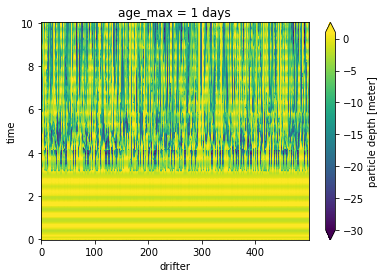

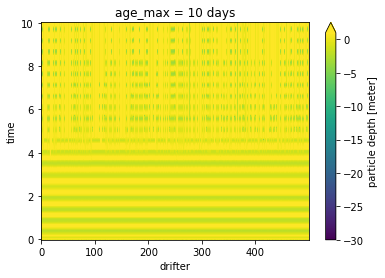

In [16]:
for a, dsr in D.items():
    plt.figure()
    dsr.depth.plot(vmin=-30, vmax=1)
    plt.title("age_max = {} days".format(a))

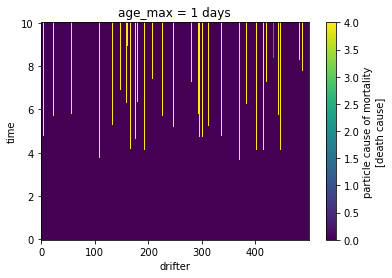

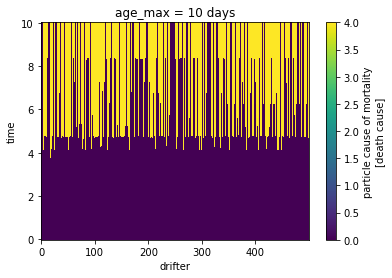

In [17]:
for a, dsr in D.items():
    plt.figure()
    dsr.mortality.plot() #(vmin=-30, vmax=1)
    plt.title("age_max = {} days".format(a))

In [18]:
dsr.mortality

<xarray.DataArray 'mortality' (time: 241, drifter: 500)>
[120500 values with dtype=int32]
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 9.875 9.917 9.958 10.0
Dimensions without coordinates: drifter
Attributes:
    long_name:      particle cause of mortality
    unit:           death cause
    alive:          0
    dead_cold:      1
    out_of_domain:  2
    old:            3
    beached:        4
    starvation:     5
    dead_hot:       6
    dead_fresh:     7
    dead_saline:    8